In [1]:
import requests
import json
import pandas as pd
import time
import re
import urllib
import matplotlib
import numpy as np
pd.set_option('display.max_colwidth', None)

In [2]:
try:
    swaps_df = pd.read_csv("./data/astro/swaps.csv")
    swaps_df.timestamp = pd.to_datetime(swaps_df.timestamp, format='mixed')
except Exception as e:
    print(f"No file yet {e}")
    swaps_df = None

In [3]:
try:
    balances_df = pd.read_csv('./data/astro/balances_20230720_polished.csv')
    balances_df['traderAddress'] = balances_df['address']
except Exception as e:
    print(f"No file yet {e}")
    balances_df = None

In [4]:
all_astro_addresses_df = balances_df.address

In [5]:
_sell = swaps_df[swaps_df.offerAsset=='ASTRO']
_buy = swaps_df[swaps_df.returnAsset=='ASTRO']
_sell['astro_amount'] =  - _sell.offerAmount
_buy['astro_amount'] =  _buy.returnAmount
swaps_df = pd.concat([_sell, _buy])

/tmp/ipykernel_107/142230925.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _sell['astro_amount'] =  - _sell.offerAmount
/tmp/ipykernel_107/142230925.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _buy['astro_amount'] =  _buy.returnAmount


tokens = [
"xASTRO",
"SAYVE",
"ORNE",
"ASTRO",
"ampLUNA",
"ROAR",
"boneLuna"
]

import requests
import json

def get_balances(address):
    url = "https://starscream-terra-mainnet.chainscope.dev/"
    headers = {
        "Content-Type": "application/json"
    }
    
    body = {
        "query": """
        query Query($address: String!, $tokenContracts: [String!]!) {
            tokenBalances(address: $address, tokenContracts: $tokenContracts)
        }
        """,
        "variables": {
            "address": f"{address}",
            "tokenContracts": [
                "terra1x62mjnme4y0rdnag3r8rfgjuutsqlkkyuh4ndgex0wl3wue25uksau39q8",
                "terra1xp9hrhthzddnl7j5du83gqqr4wmdjm5t0guzg9jp6jwrtpukwfjsjgy4f3",
                "terra19p20mfnvwh9yvyr7aus3a6z6g6uk28fv4jhx9kmnc2m7krg27q2qkfenjw",
                "terra1nsuqsk6kh58ulczatwev87ttq2z6r3pusulg9r24mfj2fvtzd4uq3exn26",
                "terra1ecgazyd0waaj3g7l9cmy5gulhxkps2gmxu9ghducvuypjq68mq2s5lvsct",
                "terra1lxx40s29qvkrcj8fsa3yzyehy7w50umdvvnls2r830rys6lu2zns63eelv",
                "terra17aj4ty4sz4yhgm08na8drc0v03v2jwr3waxcqrwhajj729zhl7zqnpc0ml"
            ]
        },
        "operationName": "Query"
    }
    
    response = requests.post(url, headers=headers, data=json.dumps(body))
    
    if response.status_code == 200:
        result = response.json()
        return result
    else:
        print("Request failed with status code:", response.status_code)

addresses = set(df.traderAddress.tolist())

balances = []
for address in addresses:
    try:
        balance_dict = {k: int(v)/1000000 for k, v in zip(tokens, get_balances(address)['data']['tokenBalances'])}
        balance_dict['traderAddress']= address
        balances.append(balance_dict)
    except:
        print(f"Error processing: {address}")

balances_df = pd.DataFrame(balances)
balances_df['total_astro_holdings'] = balances_df['ASTRO'] + balances_df['xASTRO']

df_ = pd.DataFrame(balances_df).merge(df, on='traderAddress')

In [6]:
percentile = 0.90

In [7]:
balances_df.total_astro.quantile(percentile)

2736.2254453000064

In [8]:
whales = balances_df[balances_df.total_astro > balances_df.total_astro.quantile(percentile)]
whales.head()

,address,xASTRO,ASTRO,total_astro,traderAddress
4,terra169hpn0fr2tf5un4rknndttncveshqkkq3yp6x8,13466.328110,0.000415,13466.328525,terra169hpn0fr2tf5un4rknndttncveshqkkq3yp6x8
10,terra1l3lxj26ajvywdfdxk2rl9tfvrsmep9cf4lk8f7,3713.680813,0.000000,3713.680813,terra1l3lxj26ajvywdfdxk2rl9tfvrsmep9cf4lk8f7
11,terra1m9dr95t3trn8kg2ekhrs9das9ec9vxlj46udca,3257.443875,0.000000,3257.443875,terra1m9dr95t3trn8kg2ekhrs9das9ec9vxlj46udca
12,terra1h7c6kxys36e3lwfsgqh2wlmlxym3ldzpq44d0s,32017.639863,0.000000,32017.639863,terra1h7c6kxys36e3lwfsgqh2wlmlxym3ldzpq44d0s
13,terra1kcnmyzyss02neja87d20qjayuaeufk77vsnz5a,4464.853134,136.298720,4601.151854,terra1kcnmyzyss02neja87d20qjayuaeufk77vsnz5a


In [9]:
len(whales)

1992

In [10]:
daily_delta = swaps_df[['traderAddress','date','astro_amount']].groupby(['traderAddress','date']).sum().reset_index()

In [11]:
daily_delta[["traderAddress","astro_amount"]].groupby(['traderAddress']).sum().reset_index().sort_values(by='astro_amount')

,traderAddress,astro_amount
117,terra147vzdxzn5tq4fm7z6f5q8x46xfha7e34w4sy9j,-1.194034e+06
474,terra1evtkrqahmavh4t5x6squzpwfcr4nl5ssj67edz,-1.089544e+06
762,terra1pgvewpk8kd30f2zm85sn69k9cgkp3j8szq00j7,-7.853898e+05
97,terra13vr7ewxzvaz6nj299qqt0d6w0qwqjwhu53xnrh,-7.561296e+05
51,terra12nz7cd6zyn95jhz7v923cf7sg49vpxxmy5r79p,-7.423204e+05
...,...,...
1080,terra1zakne2kmp78fp477vaqxunj0tl27leqglkc2hw,4.764188e+05
67,terra135z8ugx4gtu2ys58rt5utk3f50lwh0qxuln7ml,6.065280e+05
414,terra1djkwwpgevx42h8j7zwtgtvy2zcd2z345n5kuhn,8.484818e+05
309,terra19k3s3gv5pfm3kh4utry9ty0hsulc2n8sv5shu8,9.332778e+05


In [12]:
whales

,address,xASTRO,ASTRO,total_astro,traderAddress
4,terra169hpn0fr2tf5un4rknndttncveshqkkq3yp6x8,13466.328110,4.150000e-04,1.346633e+04,terra169hpn0fr2tf5un4rknndttncveshqkkq3yp6x8
10,terra1l3lxj26ajvywdfdxk2rl9tfvrsmep9cf4lk8f7,3713.680813,0.000000e+00,3.713681e+03,terra1l3lxj26ajvywdfdxk2rl9tfvrsmep9cf4lk8f7
11,terra1m9dr95t3trn8kg2ekhrs9das9ec9vxlj46udca,3257.443875,0.000000e+00,3.257444e+03,terra1m9dr95t3trn8kg2ekhrs9das9ec9vxlj46udca
12,terra1h7c6kxys36e3lwfsgqh2wlmlxym3ldzpq44d0s,32017.639863,0.000000e+00,3.201764e+04,terra1h7c6kxys36e3lwfsgqh2wlmlxym3ldzpq44d0s
13,terra1kcnmyzyss02neja87d20qjayuaeufk77vsnz5a,4464.853134,1.362987e+02,4.601152e+03,terra1kcnmyzyss02neja87d20qjayuaeufk77vsnz5a
...,...,...,...,...,...
19857,terra1u27ty84pa3sq8wm2hwlgupvh0wv29mshwmv0mr,0.000000,4.802039e+04,4.802039e+04,terra1u27ty84pa3sq8wm2hwlgupvh0wv29mshwmv0mr
19881,terra1ugwl4dv3egc4snhtqzff4645uv0vclv5nskelm,0.000000,3.729024e+03,3.729024e+03,terra1ugwl4dv3egc4snhtqzff4645uv0vclv5nskelm
19882,terra1kzcuzwgdum0hv2q5tlz78700d50wz5ah9crdlv,0.000000,7.027368e+04,7.027368e+04,terra1kzcuzwgdum0hv2q5tlz78700d50wz5ah9crdlv
19901,terra1jhfjnm39y3nn9l4520mdn4k5mw23nz0674c4gsvyrcr90z9tqcvst22fce,0.000000,2.962855e+07,2.962855e+07,terra1jhfjnm39y3nn9l4520mdn4k5mw23nz0674c4gsvyrcr90z9tqcvst22fce


In [13]:
whales_movements_first_july = whales.merge(daily_delta[daily_delta.date>='2023-07-01']\
                                        .traderAddress.value_counts().reset_index(),
                                               on='traderAddress', how='left').fillna(0)
whales_movements_first_july

,address,xASTRO,ASTRO,total_astro,traderAddress,count
0,terra169hpn0fr2tf5un4rknndttncveshqkkq3yp6x8,13466.328110,4.150000e-04,1.346633e+04,terra169hpn0fr2tf5un4rknndttncveshqkkq3yp6x8,0.0
1,terra1l3lxj26ajvywdfdxk2rl9tfvrsmep9cf4lk8f7,3713.680813,0.000000e+00,3.713681e+03,terra1l3lxj26ajvywdfdxk2rl9tfvrsmep9cf4lk8f7,0.0
2,terra1m9dr95t3trn8kg2ekhrs9das9ec9vxlj46udca,3257.443875,0.000000e+00,3.257444e+03,terra1m9dr95t3trn8kg2ekhrs9das9ec9vxlj46udca,0.0
3,terra1h7c6kxys36e3lwfsgqh2wlmlxym3ldzpq44d0s,32017.639863,0.000000e+00,3.201764e+04,terra1h7c6kxys36e3lwfsgqh2wlmlxym3ldzpq44d0s,0.0
4,terra1kcnmyzyss02neja87d20qjayuaeufk77vsnz5a,4464.853134,1.362987e+02,4.601152e+03,terra1kcnmyzyss02neja87d20qjayuaeufk77vsnz5a,0.0
...,...,...,...,...,...,...
1987,terra1u27ty84pa3sq8wm2hwlgupvh0wv29mshwmv0mr,0.000000,4.802039e+04,4.802039e+04,terra1u27ty84pa3sq8wm2hwlgupvh0wv29mshwmv0mr,0.0
1988,terra1ugwl4dv3egc4snhtqzff4645uv0vclv5nskelm,0.000000,3.729024e+03,3.729024e+03,terra1ugwl4dv3egc4snhtqzff4645uv0vclv5nskelm,0.0
1989,terra1kzcuzwgdum0hv2q5tlz78700d50wz5ah9crdlv,0.000000,7.027368e+04,7.027368e+04,terra1kzcuzwgdum0hv2q5tlz78700d50wz5ah9crdlv,0.0
1990,terra1jhfjnm39y3nn9l4520mdn4k5mw23nz0674c4gsvyrcr90z9tqcvst22fce,0.000000,2.962855e+07,2.962855e+07,terra1jhfjnm39y3nn9l4520mdn4k5mw23nz0674c4gsvyrcr90z9tqcvst22fce,0.0


<Axes: xlabel='count'>

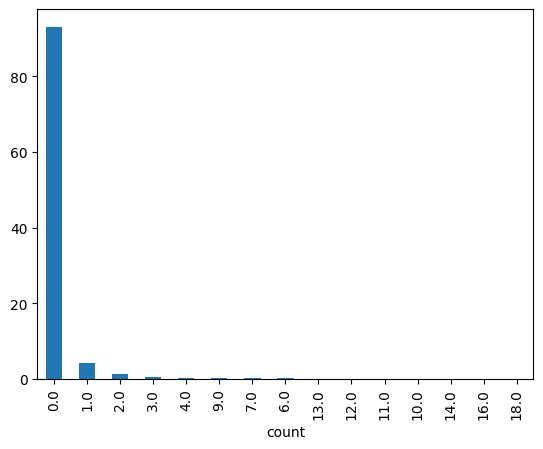

In [14]:
(whales_movements_first_july['count'].value_counts(normalize=True)*100).plot(kind='bar')

In [15]:
total_delta_astro = daily_delta[daily_delta.date>='2023-07-01']\
                    [['traderAddress','astro_amount']]\
                    .groupby('traderAddress')\
                    .sum()

In [16]:
total_delta_astro = daily_delta[daily_delta.date>='2023-07-01']\
                    [['traderAddress','astro_amount']]\
                    .groupby('traderAddress')\
                    .sum()

In [17]:
whales_delta = whales.merge(total_delta_astro, on='traderAddress', how='left').fillna(0)

<Axes: xlabel='traderAddress'>

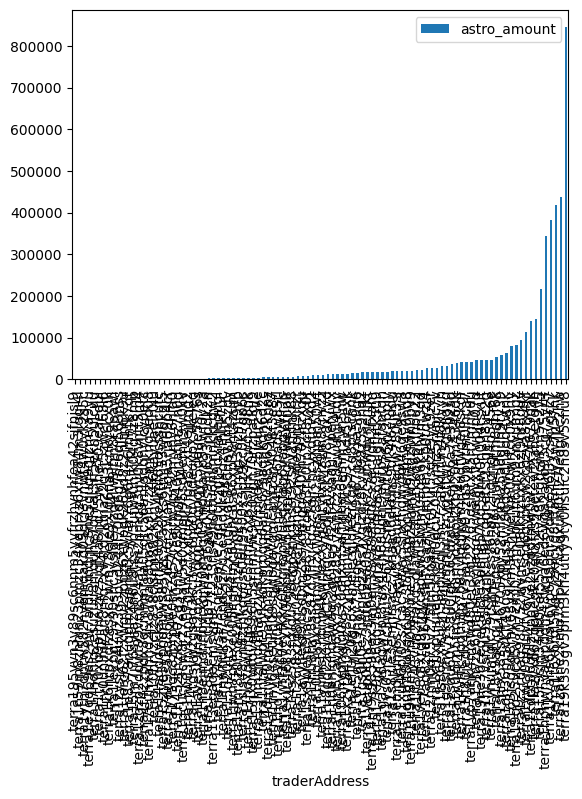

In [18]:
whales_delta[['traderAddress','astro_amount']]\
        .sort_values(by='astro_amount', ascending=True).tail(100)\
        .set_index('traderAddress').plot(kind='bar')

<Axes: xlabel='traderAddress'>

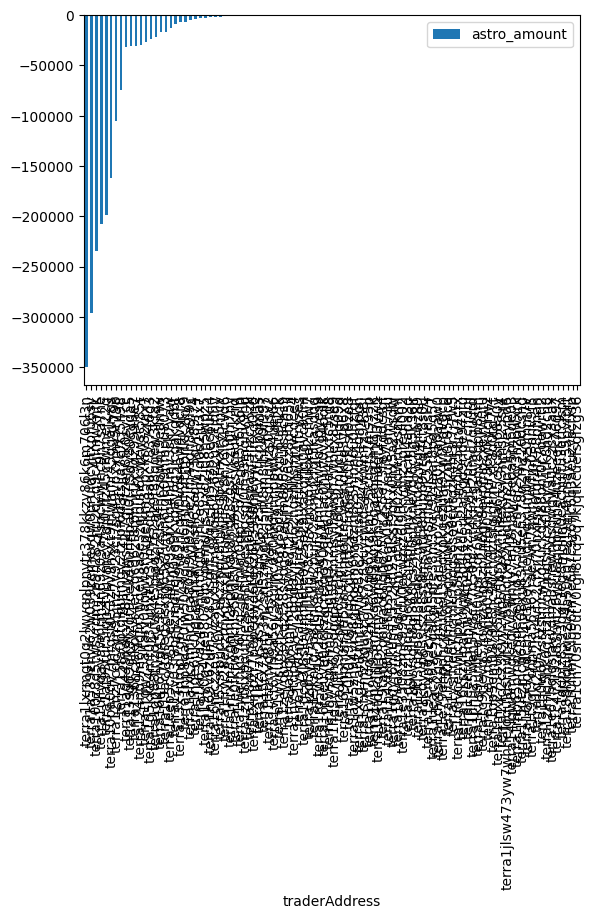

In [19]:
whales_delta[['traderAddress','astro_amount']]\
        .sort_values(by='astro_amount', ascending=True).head(100)\
        .set_index('traderAddress').plot(kind='bar')

In [20]:
def xx(x):
    if x > 100:
        return 'buyer'
    if x < -100:
        return 'seller'
    if x > -100 and x < 100:
        return 'holders'
whales_delta['whale_type'] = whales_delta.astro_amount.apply(xx)

<Axes: ylabel='count'>

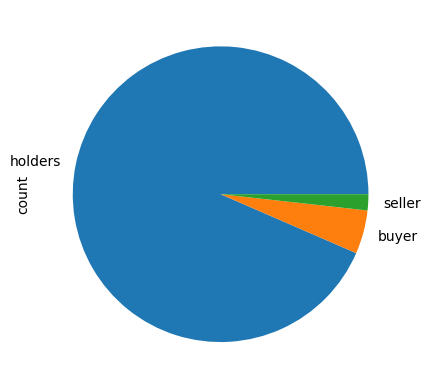

In [21]:
whales_delta.whale_type.value_counts().plot(kind='pie')